# Variational Algorithms

In [1]:
import networkx as nx
import numpy as np
import plotly.graph_objects as go
import matplotlib as mpl
import pandas as pd
from IPython.display import clear_output
from plotly.subplots import make_subplots
from matplotlib import pyplot as plt
from qiskit import Aer
from qiskit import QuantumCircuit
from qiskit.visualization import plot_state_city
from qiskit.algorithms.optimizers import COBYLA, SLSQP, ADAM
from time import time
from copy import copy
from typing import List
mpl.rcParams['figure.dpi'] = 300

## Introduction
This section serves as an introduction to the topic of variational quantum algorithms and as a recap of the material covered in the previous lecture.

### Variational quantum algorithms
In the most general sense, a variational quantum circuit is a circuit that depends on a set of parameters $\theta$. Typically, a variational quantum algorithm queries a quantum computer to sample the output of this parameterized quantum circuit for some fixed parameters and evaluates a given cost function $C(\theta)$ based on this output. A classical optimizer is then used to update the circuit parameters in order to maximize or minimize the objective function $C$. These steps are repeated in a quantum-classical hybrid loop that eventually terminates when the classical optimization has found optimal parameters $\theta^*$.<br>

Variational Quantum Algorithms are often seen as a promising method of achieving quantum advantage on near term devices. In a lot of cases they do not require the execution of deep quantum circuits and systematic errors can partly be mitigated by outsourcing the optimization procedure to a classical optimizer. Nevertheless, VQAs also face a number of challenges, in particular the questions of whether they are efficiently trainable and produce solutions that are in fact superior to those obtained by classical algorithms. 
Despite these challenges, VQAs have been proposed for a variety of problem settings, amongst others the following.

- [Variational Quantum Eigensolvers](https://qiskit.org/textbook/ch-applications/vqe-molecules.html): 
VQEs attempt to approximate the ground state and corresponding energy of a quantum system described by a Hamiltonian $H$ (i.e. the lowest eigenvalue and eigenvector of the corresponding hermitian matrix) (see [below](#variational-quantum-eigensolvers)).

- [QAOA](https://qiskit.org/textbook/ch-applications/qaoa.html): An approximate optimization algorithm used for combinatorial optimization problems. QAOA can be seen as a VQE that solves optimization problems by encoding the cost function as a problem Hamiltonian (see [Section 4](#qaoa)).

- Variational Classifiers: A variational classifier is a quantum circuit that is trained on a data set to classify unseen data samples, reminiscent of classical machine learning classifiers. 

- [Variational Quantum Linear Solvers](https://qiskit.org/textbook/ch-paper-implementations/vqls.html): VQLS solves systems of linear equations by leveraging the basic ideas behind VQEs.



In this lab, we will focus on QAOA as a special case of the Variational Quantum Eigensolver. 

### The Variational Method
Consider a Hermitian operator $H$ describing a quantum system with corresponding ground state $\vert \psi^* \rangle$ and ground state energy $E_0$.
The variational method is a technique to approximate $\vert \psi^* \rangle$ and $E_0$. This is done by choosing a parameterized trial state $\vert \psi(\theta) \rangle$, where $\theta$ denotes a set or vector of parameters. Recall that the energy of the system in the state $\vert \psi \rangle$ is given by its expectation value with respect to $H$
$$
E(\vert \psi \rangle)= \langle \psi \vert H \vert \psi \rangle
$$
Since the ground state of the system is the lowest energy eigenstate, by definition it holds that
$$
E_0 = \langle \psi^* \vert H \vert \psi^* \rangle \leq \langle \psi(\theta) \vert H \vert \psi(\theta) \rangle,
$$
for any parameters $\theta$. Thus, by minimizing the expectation value of the trial state $\psi(\theta)$, that is, finding parameters $\theta$ for which the expectation value $\langle \psi(\theta) \vert H \vert \psi(\theta) \rangle$ becomes as small as possible, we obtain an upper bound on the ground state energy $E_0$ and an approximation of the ground state itself. Naturally, the choice of a good trial state $\psi(\theta)$ is principal to the success of the variational method.

### Variational Quantum Eigensolvers
Variational quantum eigensolvers use the variational method to approximate the ground state and minimal eigenvalue of a Hamiltonian $H$. The trial state now corresponds to a quantum state prepared by a variational quantum circuit and the corresponding expectation value is measured by executing the circuit on a quantum computer. A classical optimizer is then used to tune the circuit parameters and minimize the measured expectation value.<br>

<div>
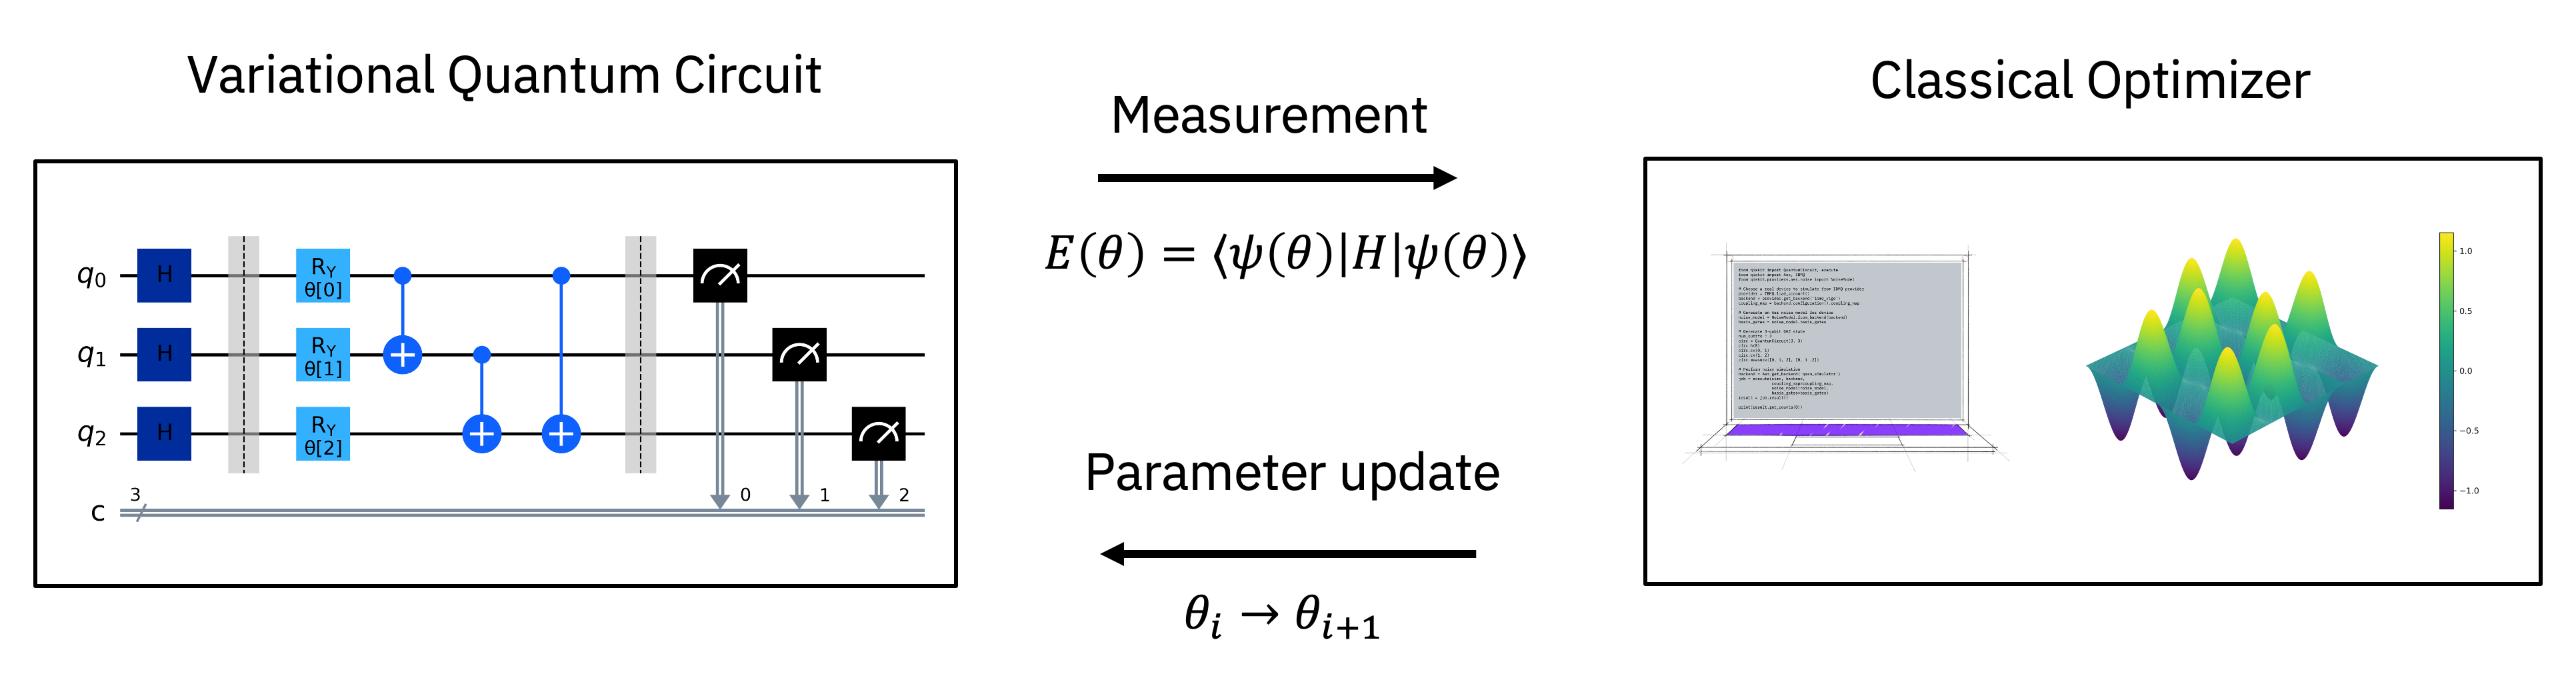
</div>

Apart from being applicable to problems in chemistry or quantum mechanics itself, where we are directly interested in the ground state of a given Hamiltonian, one can also use the concept of variational quantum eigensolvers for optimization problems, by encoding the cost function that should be optimized as a Hamiltonian whose ground state corresponds to the optimal solution of the problem. This idea lies at the heart of QAOA.



## Parameterized Quantum Circuits
Constructing parameterized circuits and assign values to circuit parameters in Qiskit, allowing us to build custom variational forms.

### Constructing a parameterized circuit
Creating a quantum circuit with parameters in Qiskit is not much different from creating a standard quantum circuit. We simply initialize parameters using Qiskit's ```Parameter``` class and use them accordingly when appending gates to the constructed circuit. In the following example, we use parameters for the rotation angle of rotational quantum gates.

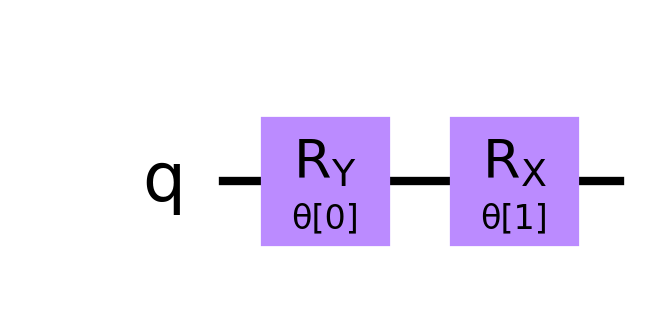

In [2]:
from qiskit.circuit import Parameter, ParameterVector
#Parameters are initialized with a simple string identifier
parameter_0 = Parameter('θ[0]')
parameter_1 = Parameter('θ[1]')
circuit = QuantumCircuit(1)
#We can then pass the initialized parameters as the rotation angle argument to the Rx and Ry gates
circuit.ry(theta = parameter_0, qubit = 0)
circuit.rx(theta = parameter_1, qubit = 0)
circuit.draw('mpl')

The same parameter can also be used multiple times within the same circuit. Consider the circuit form as above, but with the same parameter used repeatedly for different gates.

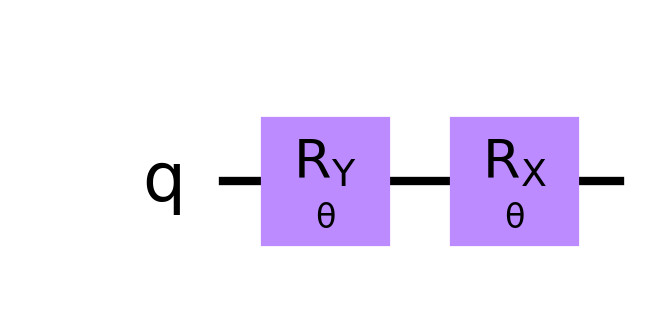

In [3]:
parameter = Parameter('θ')
circuit = QuantumCircuit(1)
circuit.ry(theta = parameter, qubit = 0)
circuit.rx(theta = parameter, qubit = 0)
circuit.draw('mpl')

For convenience, there also exists a ```ParameterVector``` class in Qiskit which allows for the creation of multiple parameters at once. Consider the following example of a RealAmplitudes circuit, which consists of alternating layers of parameterized $R_Y$ gates and entangling $CX$ gates. The [RealAmplitudes](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RealAmplitudes.html) variational form is commonly used for classification in quantum machine learning and can also be found in the [circuit library](https://qiskit.org/documentation/apidoc/circuit_library.html) of Qiskit.

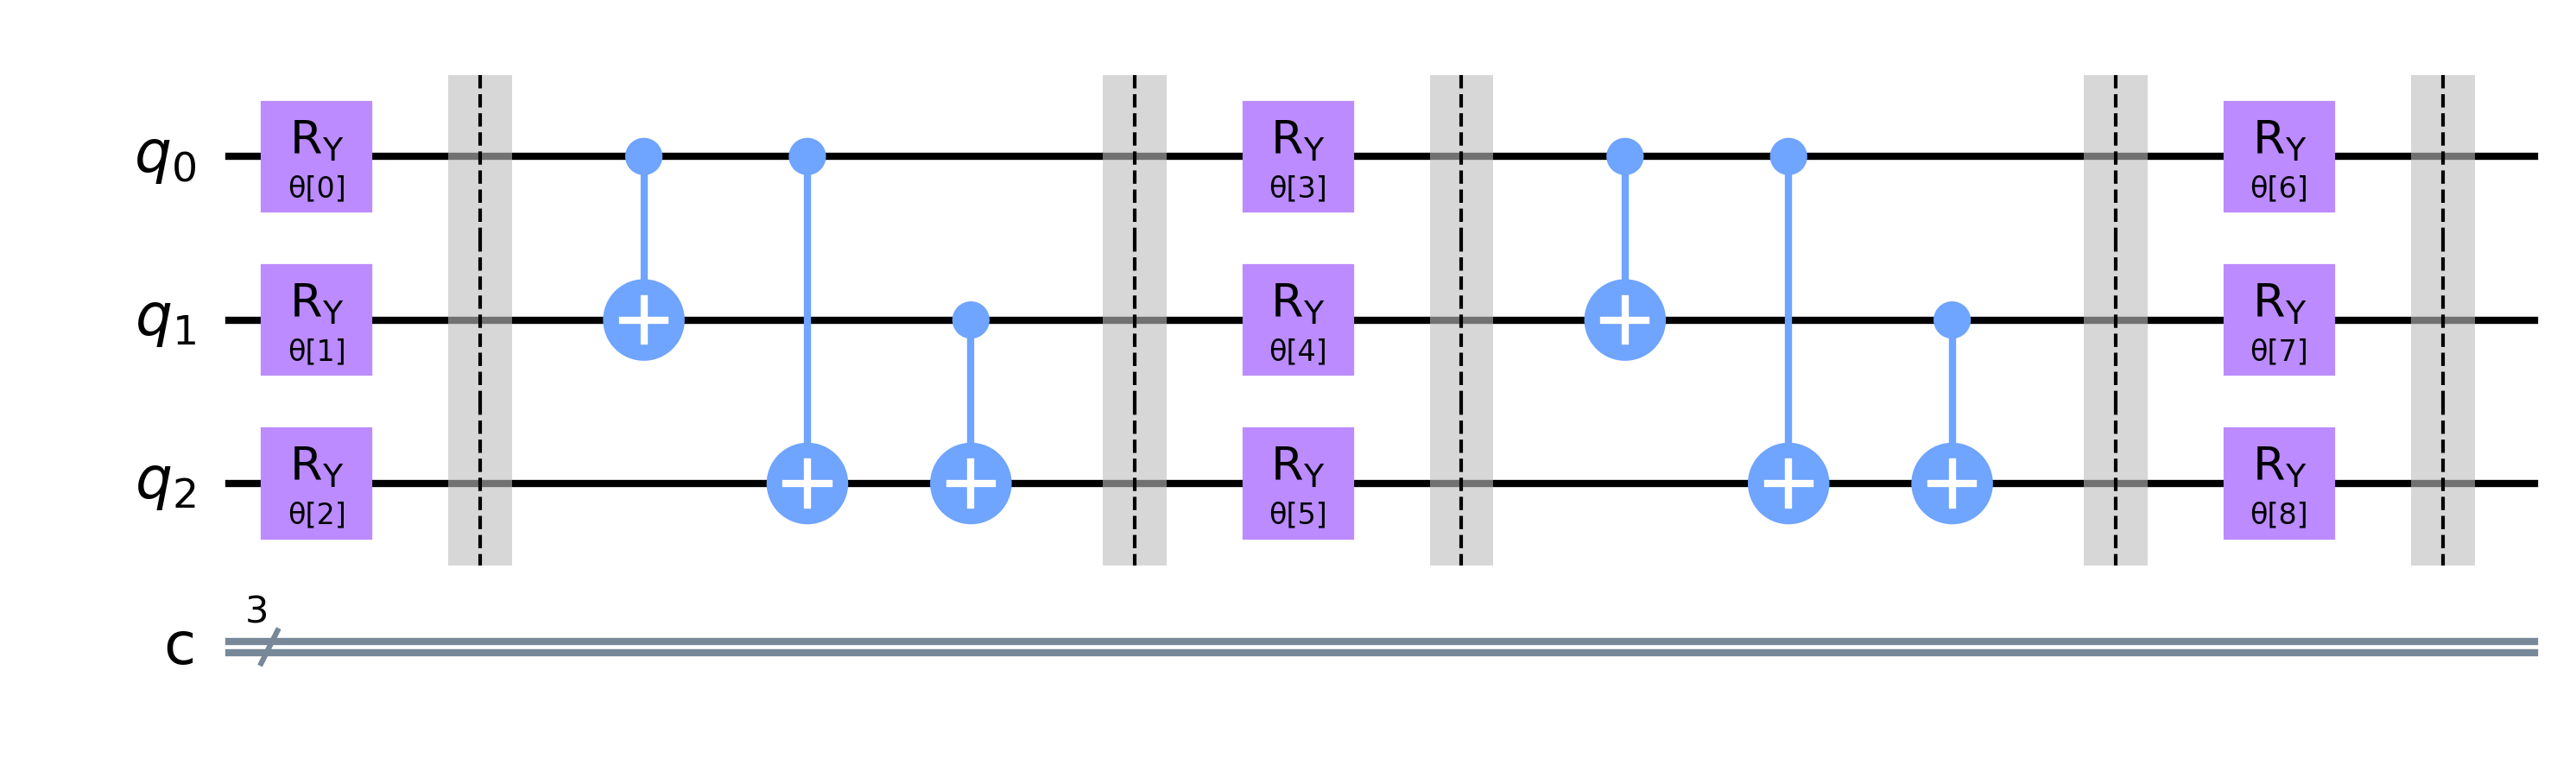

In [4]:
#Set the number of layers and qubits
n=3
num_layers = 2

#ParameterVectors are initialized with a string identifier and an integer specifying the vector length
parameters = ParameterVector('θ', n*(num_layers+1))


circuit = QuantumCircuit(n, n)
for layer in range(num_layers):
    #Appending the parameterized Ry gates using parameters from the vector constructed above
    for i in range(n):
        circuit.ry(parameters[n*layer+i], i)
    circuit.barrier()

    #Appending the entangling CNOT gates
    for i in range(n):
        for j in range(i):
                circuit.cx(j,i)
    circuit.barrier()

#Appending one additional layer of parameterized Ry gates
for i in range(n):
    circuit.ry(parameters[n*num_layers+i], i)
circuit.barrier()

circuit.draw('mpl')

We can inspect the parameters that are part of a quantum circuit.


In [5]:
print(circuit.parameters)

ParameterView([ParameterVectorElement(θ[0]), ParameterVectorElement(θ[1]), ParameterVectorElement(θ[2]), ParameterVectorElement(θ[3]), ParameterVectorElement(θ[4]), ParameterVectorElement(θ[5]), ParameterVectorElement(θ[6]), ParameterVectorElement(θ[7]), ParameterVectorElement(θ[8])])


### Assigning values to parameters
A parameterized circuit cannot be executed on a quantum backend until the parameters have been assigned fixed values. To do so, we can use the `QuantumCircuit` methods 
```
assign_parameters(parameters, inplace = False)
bind_parameters(values)
```
`bind_parameters` assigns numeric values to the parameters of the circuit, always yielding a new circuit. With `assign_parameters`, one can assign numeric values or substitute parameters by other parameter expressions. Additionally, with `assign_parameters` it is possible to substitute parameters in place instead of yielding a new circuit. The values or parameter expressions that should be assigned to the circuit parameters can be provided either as a dictionary, where the dictionary keys correspond to the parameters in the circuit and the dictionary values are the values to bind, or as an iterable of values. In the latter case values are assigned to parameters in the same order as parameters were added to the circuit.

{ParameterVectorElement(θ[0]): 0.5422067594418662, ParameterVectorElement(θ[1]): 0.5464918790060849, ParameterVectorElement(θ[2]): 0.4544353079017479, ParameterVectorElement(θ[3]): 0.40429935416980634, ParameterVectorElement(θ[4]): 0.27058427005650854, ParameterVectorElement(θ[5]): 0.5849150710214772, ParameterVectorElement(θ[6]): 0.6464441377945376, ParameterVectorElement(θ[7]): 0.16543345039439716, ParameterVectorElement(θ[8]): 0.6954060685175558}


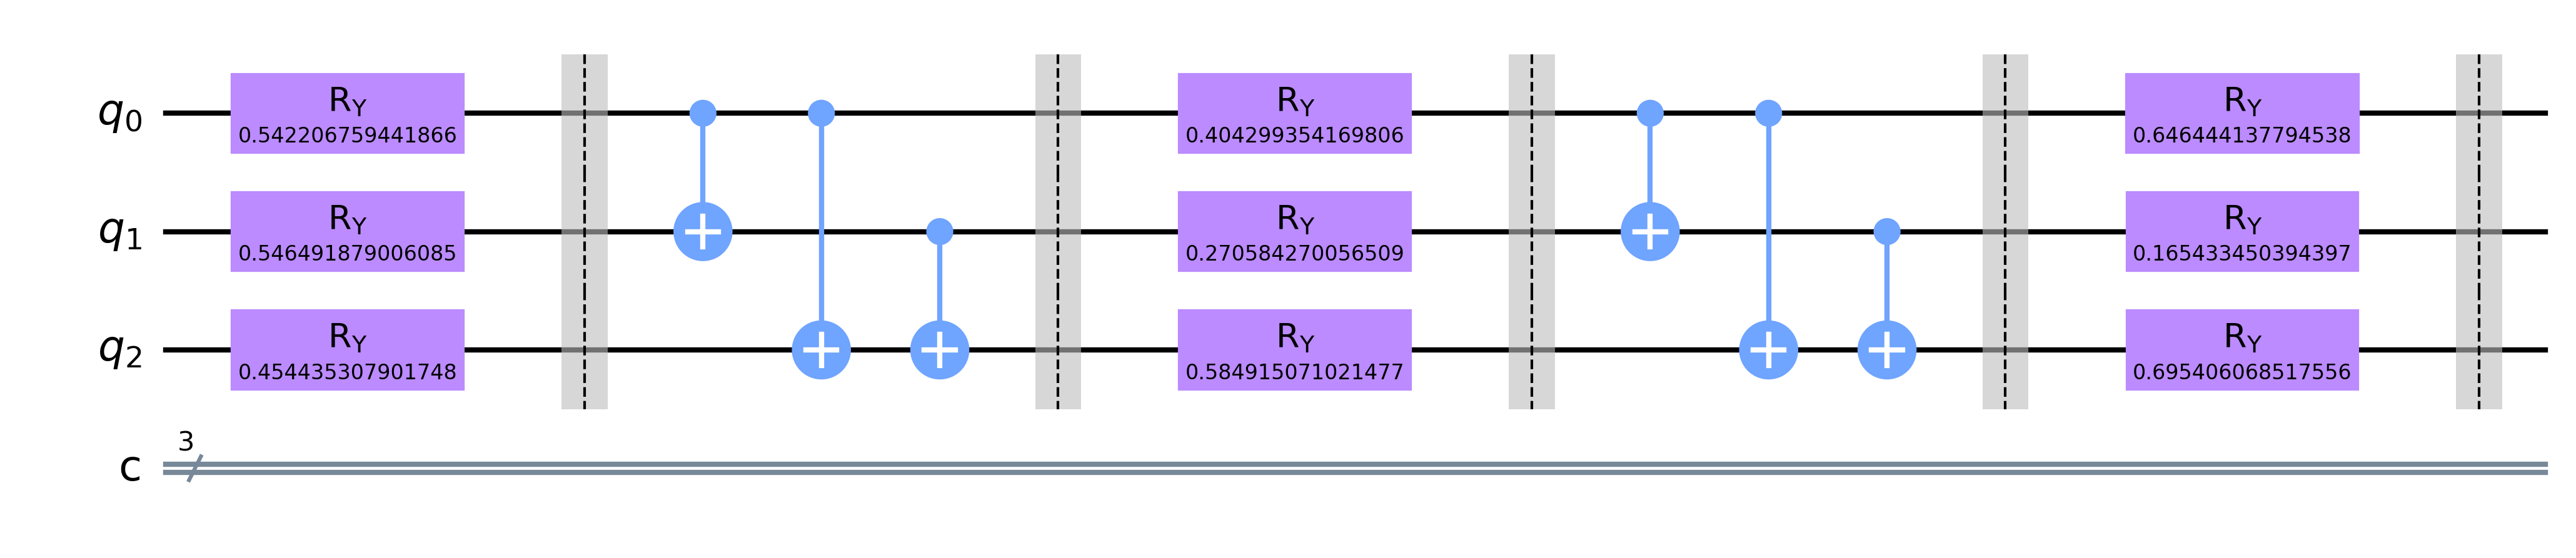

In [6]:
#Create parameter dictionary with random values to bind
param_dict = {parameter: np.random.random() for parameter in parameters}
print(param_dict)
#Assign parameters using the assign_parameters method
bound_circuit = circuit.assign_parameters(parameters = param_dict)
bound_circuit.draw('mpl')

Consider also the following circuit, where we substitute a parameter from the original circuit by another parameter expression.

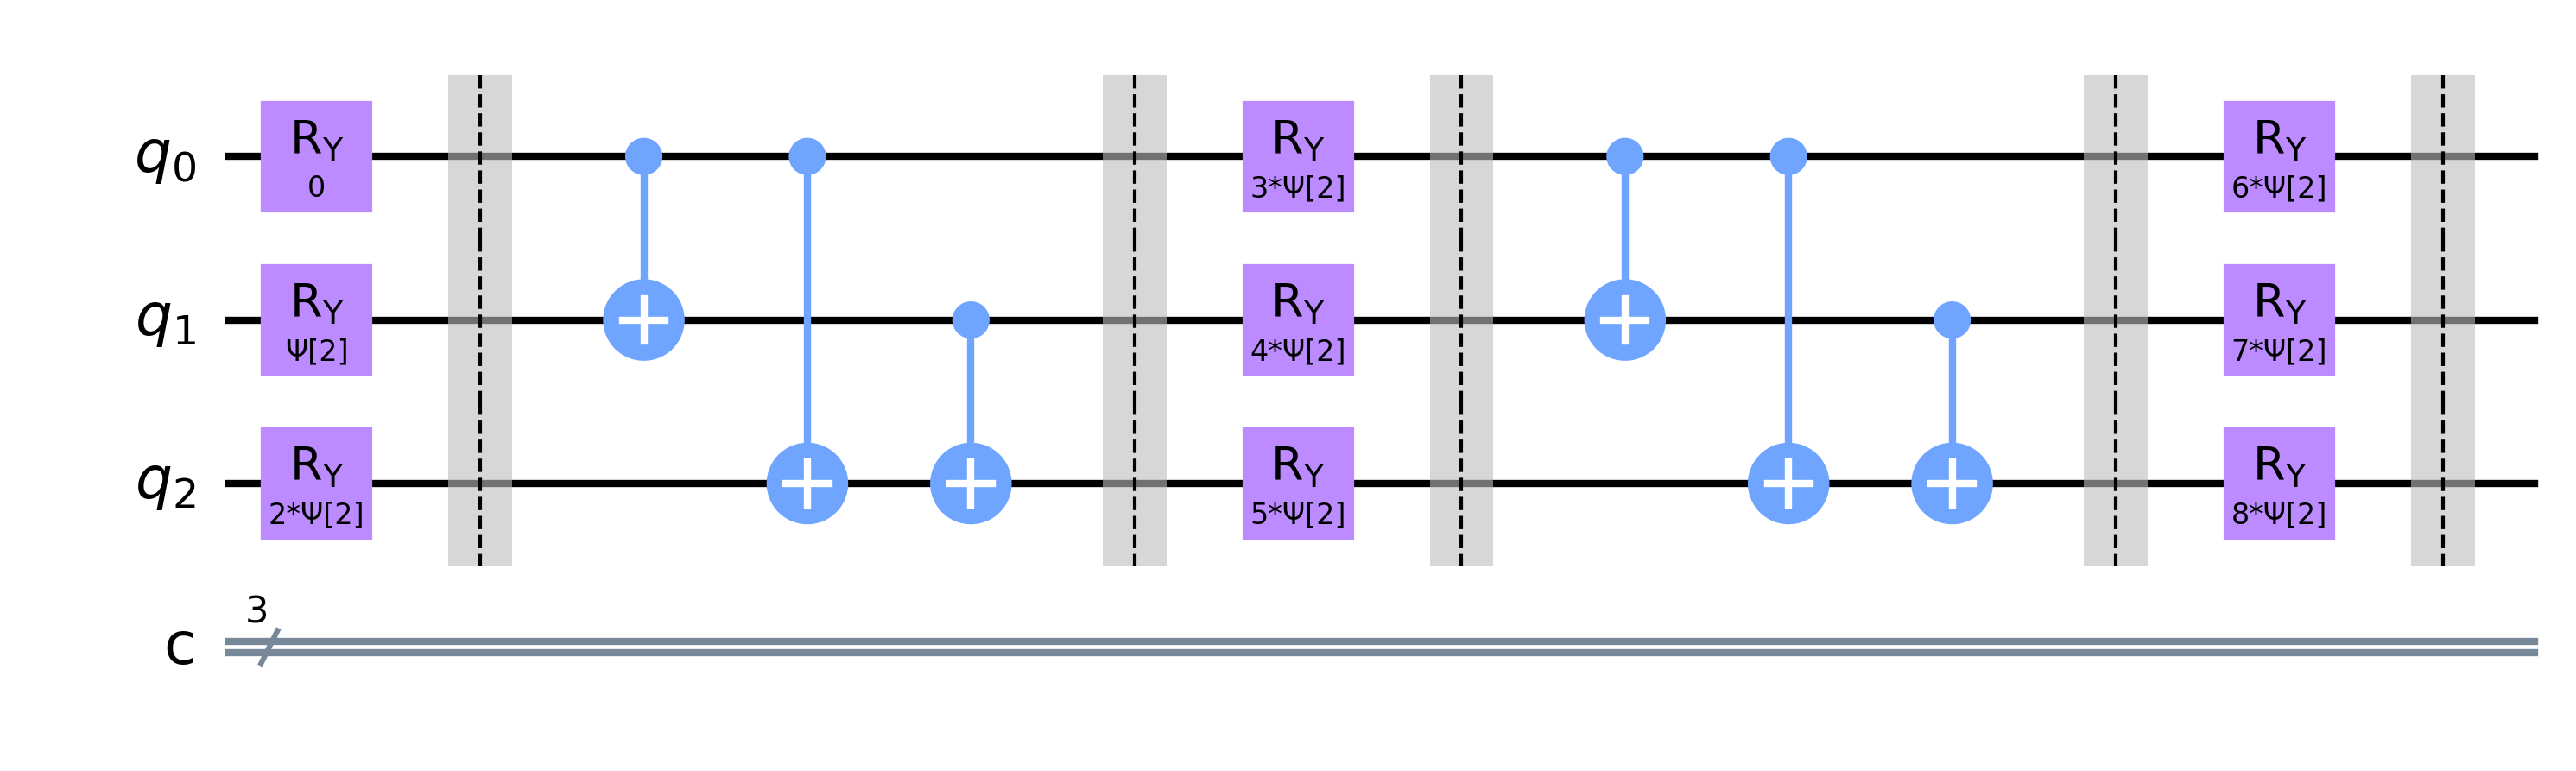

In [7]:
new_parameters = ParameterVector('Ψ',9)
new_circuit = circuit.assign_parameters(parameters = [k*new_parameters[i] for k in range(9)])
new_circuit.draw('mpl')

The bound version of the circuit can now be executed on a quantum device. Attempting to execute a parameterized quantum circuit with non-assigned parameters will throw an error.

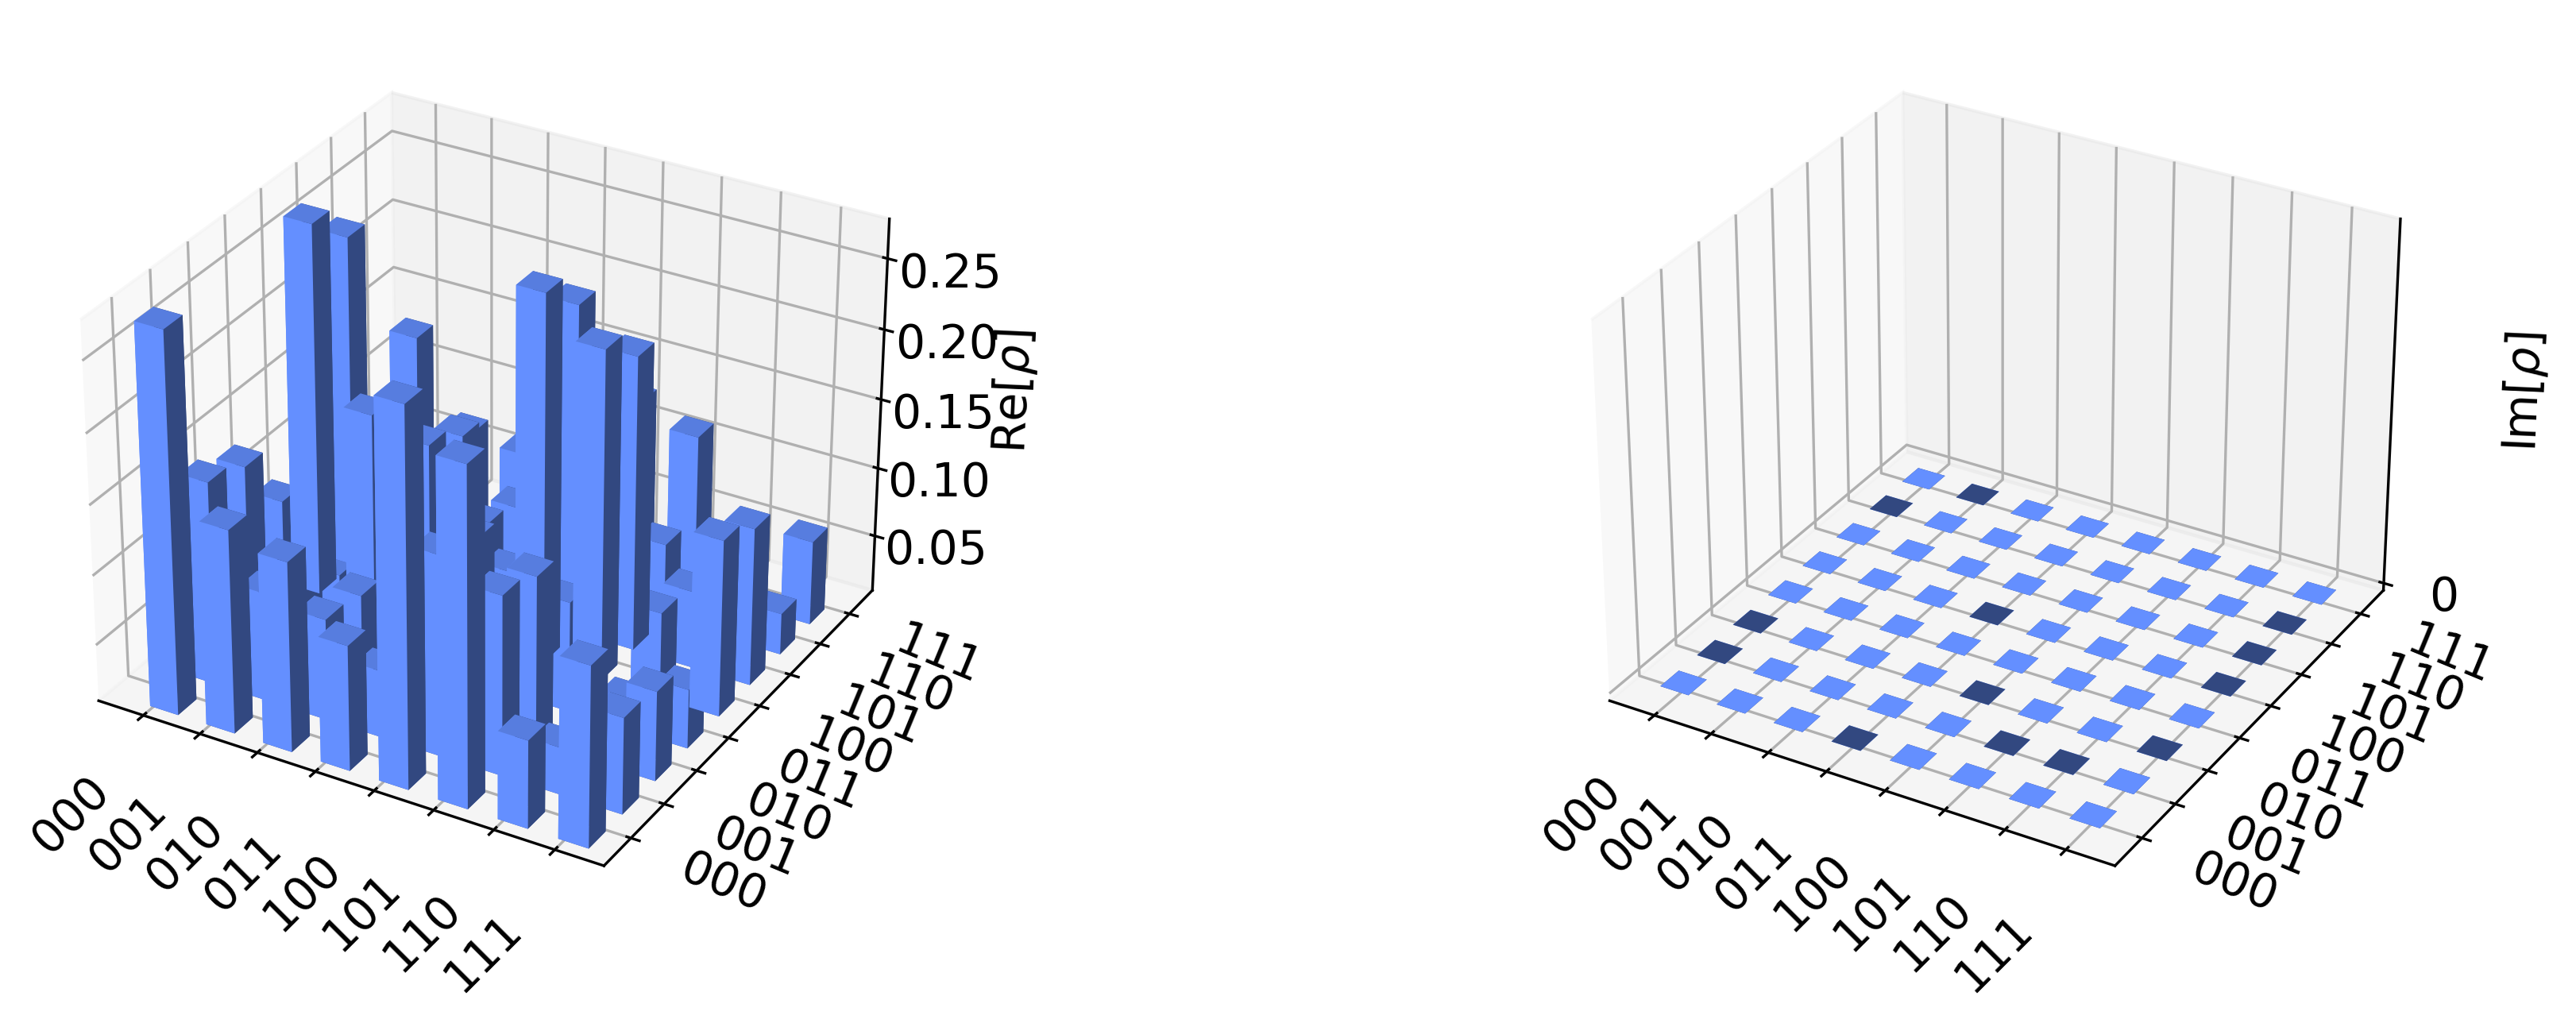

In [8]:
#Run the circuit with assigned parameters on Aer's statevector simulator
simulator = Aer.get_backend('statevector_simulator')
result = simulator.run(bound_circuit).result()
statevector = result.get_statevector(bound_circuit)
plot_state_city(statevector)

In [9]:
#The following line produces an error when run because 'circuit' still contains non-assigned parameters
#result = simulator.run(circuit).result()